In [0]:
import torch
import torch.nn as nn
import torch.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

#Data Loading and preprocessing

In [0]:
epoch = 10
batch_size =100
learning_rate = 0.0005

# Download Data

cifar_train = dset.CIFAR10("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test  = dset.CIFAR10("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# Set Data Loader(input pipeline)

train_loader = torch.utils.data.DataLoader(dataset=cifar_train, batch_size=batch_size, shuffle=True)

 
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#Convolutional Auto Encoder

In [0]:
# Encoder

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size=3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size=3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size=3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size=3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 16 x 16
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size=3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(in_channels = 128,out_channels = 128,kernel_size=3,padding=1),  # batch x 128 x 16 x 16
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size=3,padding=1),  # batch x 256 x 8 x 8
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        # print(out)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

In [0]:
# Decoder 

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,(2, 2),2,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,(3, 3),1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,(3, 3),1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,(3, 3),1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,(2, 2),2,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,(3, 3),1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,(3, 3),1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,8,8)
        out = self.layer1(out)
        # print("Layer 1",out.shape)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [0]:
# Check output of autoencoder

for image,label in train_loader:
    image = image.cuda()
    # print("Image",image.shape)
    output = encoder(image)
    print("Encoder",output.shape)
    output = decoder(output)
    # print("Output",output.shape)
    break

Encoder torch.Size([100, 16384])


In [0]:

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

#CAE without Noise

In [0]:
for i in range(epoch):
    for image,label in train_loader:
        image = image.cuda()
        optimizer.zero_grad()
        output_encoder = encoder(image)
        output_decoder = decoder(output_encoder)
        loss = loss_func(output_decoder,image)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
#torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
print(loss)

epoch [1/10], loss:0.0088
epoch [2/10], loss:0.0052
epoch [3/10], loss:0.0048
epoch [4/10], loss:0.0043
epoch [5/10], loss:0.0034
epoch [6/10], loss:0.0032
epoch [7/10], loss:0.0024
epoch [8/10], loss:0.0028
epoch [9/10], loss:0.0026
epoch [10/10], loss:0.0030
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward>)


Actual Input


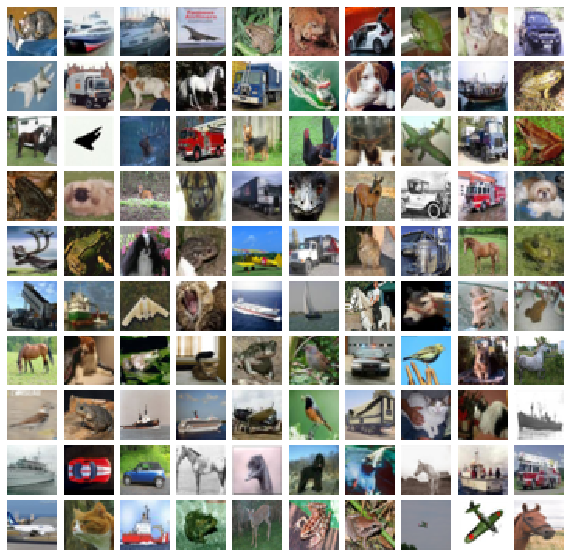

Reconstructed Output


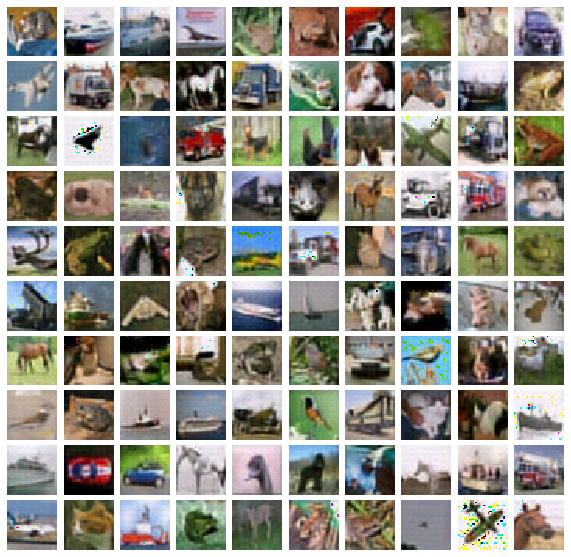

In [0]:
import numpy as np

def plot_img(tensor, num_cols=10):
  num_imgs = tensor.shape[0]
  num_rows = 1+ num_imgs // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(num_imgs):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(tensor[i].transpose((1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show() 

for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()
    output = encoder.forward(images)
    output = decoder.forward(output)
    break

print('Actual Input')
plot_img(images.detach().cpu().numpy())
print('Reconstructed Output')
plot_img(((output.detach().cpu().numpy())*255).astype(np.uint8))   

#Adding Denoising to CAE

In [0]:

#Adding noise to the input image
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [0]:
for i in range(epoch):
    for image,label in train_loader:
        image_n = add_noise(image)
        image = image.cuda()
        image_n = image_n.cuda()
        optimizer.zero_grad()
        output_encoder = encoder(image_n)
        output_decoder = decoder(output_encoder)
        loss = loss_func(output_decoder,image)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
#torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
print(loss)

epoch [1/10], loss:0.0042
epoch [2/10], loss:0.0044
epoch [3/10], loss:0.0040
epoch [4/10], loss:0.0040
epoch [5/10], loss:0.0042
epoch [6/10], loss:0.0086
epoch [7/10], loss:0.0055
epoch [8/10], loss:0.0050
epoch [9/10], loss:0.0045
epoch [10/10], loss:0.0053
tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward>)


Actual Input


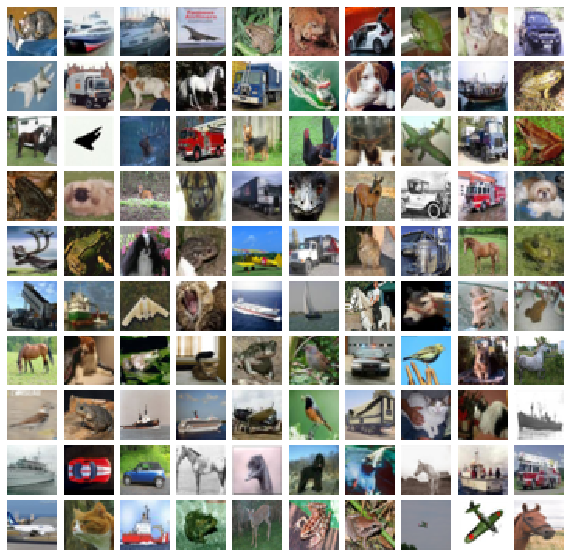

Reconstructed Output


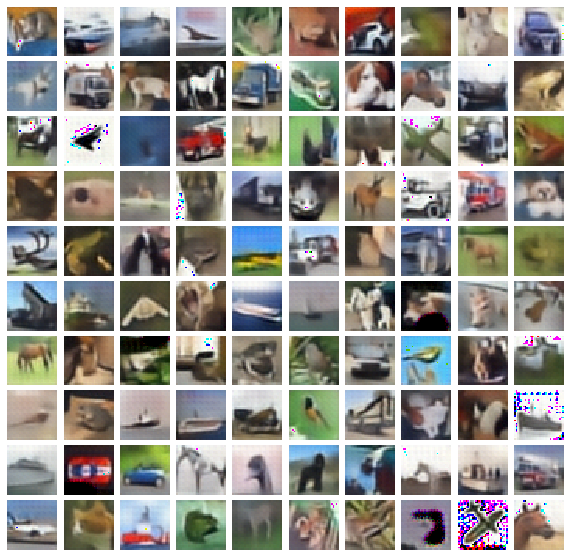

In [0]:
import numpy as np

def plot_img(tensor, num_cols=10):
  num_imgs = tensor.shape[0]
  num_rows = 1+ num_imgs // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(num_imgs):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(tensor[i].transpose((1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show() 

for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()
    output = encoder.forward(images)
    output = decoder.forward(output)
    break

print('Actual Input')
plot_img(images.detach().cpu().numpy())
print('Reconstructed Output')
plot_img(((output.detach().cpu().numpy())*255).astype(np.uint8))

#Latent Space for Classification

In [0]:
class Classification(nn.Module):
    def __init__(self, n_embedded):
        super(Classification, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(n_embedded, 400),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(400, 10),
        )
    def forward(self, x):
        out = self.classifier(x)
        return out
        
model = Classification(256*8*8)
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
            
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15
   


In [0]:
for epoch in range(epochs): 
    batch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
         
        images = images.cuda()
        encoded = encoder(images).cuda()
        labels = labels.cuda()     
        optimizer.zero_grad()
        out = model(encoded)
        loss = criterion(out, labels)
        batch_loss = batch_loss + loss.item()
        loss.backward()
        optimizer.step()
    print("Epoch:",epoch, "Loss:", batch_loss/len(train_loader))


Epoch: 0 Loss: 1.8437910573482514
Epoch: 1 Loss: 1.377883264064789
Epoch: 2 Loss: 1.3077681460380555
Epoch: 3 Loss: 1.2687358311414718
Epoch: 4 Loss: 1.236607378602028
Epoch: 5 Loss: 1.1864077056646347
Epoch: 6 Loss: 1.163165876865387
Epoch: 7 Loss: 1.15470104265213
Epoch: 8 Loss: 1.1331565392017364
Epoch: 9 Loss: 1.1149451340436936
Epoch: 10 Loss: 1.0873772416114806
Epoch: 11 Loss: 1.076676263332367
Epoch: 12 Loss: 1.0681454570293427
Epoch: 13 Loss: 1.0396561225652694
Epoch: 14 Loss: 1.0418011512756347


In [0]:
total = 0
correct = 0
for images, labels in test_loader:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    images = images.cuda()
    encoded = encoder(images).cuda()

    # Forward pass only to get logits/output
    outputs = model(encoded)
    
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
      
    # Total number of labels
    total += labels.size(0)
      
    # Total correct predictions
    correct += (predicted.cpu() == labels.cpu()).sum().float()
  
accuracy = 100. * correct / total
print("Accuracy", accuracy.item())

Accuracy 55.709999084472656


#Latent space classification for robot classification

In [0]:
!git clone https://github.com/TejasMorbagal/DenseNet.git

fatal: destination path 'DenseNet' already exists and is not an empty directory.


In [0]:
from torchvision import datasets, models, transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'DenseNet/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

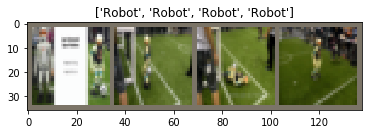

In [0]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
batch_size = 4
model = Classification(256*8*8)
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
            
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
   
for epoch in range(epochs): 
    batch_loss = 0
    for i, (images, labels) in enumerate(dataloaders['train']):
         
        batch_len = images.size()[0]
        if batch_size == batch_len:
          images = images.cuda()
          encoded = encoder(images).cuda()
          labels = labels.cuda()     
          optimizer.zero_grad()
          out = model(encoded)
          loss = criterion(out, labels)
          batch_loss = batch_loss + loss.item()
          loss.backward()
          optimizer.step()
    print("Epoch:",epoch, "Loss:", batch_loss/len(dataloaders))


Epoch: 0 Loss: 686.3230166435242
Epoch: 1 Loss: 60.549689799547195
Epoch: 2 Loss: 16.446035027503967
Epoch: 3 Loss: 13.986849620938301
Epoch: 4 Loss: 12.80100965499878
Epoch: 5 Loss: 18.875549238175154
Epoch: 6 Loss: 28.08900073170662
Epoch: 7 Loss: 24.789309750311077
Epoch: 8 Loss: 22.58466792013496
Epoch: 9 Loss: 26.922678865492344


In [0]:
total = 0
correct = 0
for images, labels in dataloaders['val']:
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    batch_len = images.size()[0]
    if batch_len == batch_size:
      images = images.cuda()
      encoded = encoder(images).cuda()

      # Forward pass only to get logits/output
      outputs = model(encoded)
      
      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)
        
      # Total number of labels
      total += labels.size(0)
        
      # Total correct predictions
      correct += (predicted.cpu() == labels.cpu()).sum().float()
  
accuracy = 100. * correct / total
print("Accuracy", accuracy.item())

Accuracy 85.9756088256836
